# Imports and Tensorflow set up

In [1]:
# workaround if you have not yet installed CherenkovDeconvolution.py but want to try it from this notebook
import sys

sys.path.insert(0,'/net/nfshome/home/shaefs/CherenkovDeconvolution.py')

In [2]:
from cherenkovdeconvolution import dsea

import numpy as np
np.random.seed(42)

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
import csv

In [3]:
with tf.compat.v1.Session() as sess:
  devices = sess.list_devices()
devices

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 5020061459516484584),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12563897739877181644),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 22679594599, 3353422164725646961),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:1, GPU, 22679594599, 5928077124112180810),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 3821115251561089935),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:1, XLA_GPU, 17179869184, 5578814132688480233)]

# Deep Neural Network

In [4]:
# train a new model or select existing model_weights
model_trained = True
weights_name = 'weights_feature_list'

In [5]:
# neural network
def make_model(num_features, num_classes, learning_rate=0.0005):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(120, input_shape=num_features))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(240, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(12, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # compile the NN
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metric = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

    model.compile(optimizer=opt, loss=loss, metrics=[metric])

    return model

# Read-in and preprocessing

In [6]:
# Feature Selection
feature_list = ['SplineMPEDirectHitsICE.n_dir_doms', 
                        'VariousVariables.Cone_Angle',
                        'SplineMPECramerRaoParams.variance_theta',
                        'Borderness.Q_ratio_in_border',
                        'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
                        'SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy',
                        'SplineMPEDirectHitsICB.n_late_doms',
                        'Dustyness.n_doms_in_dust',
                        'LineFitGeoSplit1Params.n_hits',
                        'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
                        'SPEFit2GeoSplit1BayesianFitParams.logl',
                        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom']
#feature_list = ['MCPrimary.energy']



In [7]:
# just read-in necessary columns
fields = feature_list + ['MCPrimary.energy']

In [8]:
# read in data
file_path = '/net/big-tank/POOL/users/lkardum/new_mc_binning.csv'
df_raw = pd.read_csv(file_path, skipinitialspace=True, usecols=fields)
df_raw

,SplineMPECramerRaoParams.variance_theta,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,MCPrimary.energy,SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness,SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value,SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom,LineFitGeoSplit1Params.n_hits,SplineMPEDirectHitsICB.n_late_doms,SplineMPEDirectHitsICE.n_dir_doms,Borderness.Q_ratio_in_border,SPEFit2GeoSplit1BayesianFitParams.logl,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle
0,0.000138,20601.845970,3086.645078,-0.147665,0.397322,41.003142,19.0,34.0,20.0,0.101743,158.569898,0.175000,0.022686
1,0.003101,9461.487291,193.041166,0.344174,0.545559,50.324590,39.0,13.0,11.0,0.011322,272.450606,0.057143,0.097690
2,0.000325,43222.679757,862.503704,0.281681,0.463602,39.265226,21.0,20.0,17.0,0.618235,73.385557,0.217391,0.049914
3,0.000066,9929.465219,288.757353,0.222210,0.397322,16.576652,12.0,16.0,13.0,0.041282,81.277756,0.875000,0.023061
4,0.001243,14979.867844,1838.155763,-0.233723,0.545559,11.832243,16.0,16.0,13.0,0.979636,90.623889,0.294118,0.222784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,0.002613,28988.905556,2680.561232,-0.204343,0.545559,24.473264,5.0,13.0,11.0,0.000000,56.708233,0.000000,0.149460
13336409,0.000112,13010.699980,1695.794619,0.567237,0.342283,41.072783,110.0,58.0,23.0,0.002037,302.582772,0.555556,0.134817
13336410,0.010503,15232.377792,579.684909,0.317987,0.545559,45.828011,13.0,19.0,17.0,0.274274,108.338541,0.125000,0.090354
13336411,0.004765,19444.610677,205.607328,0.341417,0.545559,42.645669,13.0,12.0,8.0,0.000000,107.530913,0.000000,0.128185


In [9]:
# drop critical rows
df = df_raw.drop([ 1007671,  1426233,  2304853,  2715790,  3674355,  3741687, 4178063,  4969266,  5038333,  5334552,  5589516,  5863719,
 5978972,  7006367,  7281704,  7509650,  8380383,  8758113,9043798, 10280382, 11179530, 11184928, 11332586, 11797767,12253944], axis = 0)

# substitute NaNs with extreme Value
df.fillna(value =-100000, inplace = True)

In [10]:
# write column names to csv
columns = df.columns.to_list()
df_temp = pd.DataFrame(data=columns)
df_temp.to_csv('output/columns.csv', index=False)
columns

['SplineMPECramerRaoParams.variance_theta',
 'SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy',
 'MCPrimary.energy',
 'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
 'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
 'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom',
 'LineFitGeoSplit1Params.n_hits',
 'SplineMPEDirectHitsICB.n_late_doms',
 'SplineMPEDirectHitsICE.n_dir_doms',
 'Borderness.Q_ratio_in_border',
 'SPEFit2GeoSplit1BayesianFitParams.logl',
 'Dustyness.n_doms_in_dust',
 'VariousVariables.Cone_Angle']

In [11]:
# plot correlations between the features

# plt.figure(figsize=(200,200))
# ax = sns.heatmap(df[feature_list].corr(), annot=True, square=True, cmap='coolwarm')

# #fix bug in matlotlib 3.1.0/1
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)
# plt.savefig('output/feature_cor.pdf')
# plt.show()

# Discretize the target Neutrino Energy

In [12]:
# discretize
df['MCPrimary.energy'].describe()

count    1.333639e+07
mean     6.298949e+03
std      2.457562e+05
min      1.000001e+02
25%      2.706783e+02
50%      5.471676e+02
75%      1.416143e+03
max      9.970067e+07
Name: MCPrimary.energy, dtype: float64

In [28]:
# Variables: Label
# drop out all events with Energies outside the range
lower_limit = 100
upper_limit = 10**5

# Variables: NN
num_bins = 10 # number of bins (energy classes), output_shape

In [29]:
# throw out extreme high and low energy neutrinos
df = df[(df['MCPrimary.energy']<upper_limit) & (df['MCPrimary.energy']>lower_limit)]
df

,SplineMPECramerRaoParams.variance_theta,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,MCPrimary.energy,SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness,SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value,SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom,LineFitGeoSplit1Params.n_hits,SplineMPEDirectHitsICB.n_late_doms,SplineMPEDirectHitsICE.n_dir_doms,Borderness.Q_ratio_in_border,SPEFit2GeoSplit1BayesianFitParams.logl,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle,E_discr
0,0.000138,20601.845970,3086.645078,-0.147665,0.397322,41.003142,19.0,34.0,20.0,0.101743,158.569898,0.175000,0.022686,2
1,0.003101,9461.487291,193.041166,0.344174,0.545559,50.324590,39.0,13.0,11.0,0.011322,272.450606,0.057143,0.097690,0
2,0.000325,43222.679757,862.503704,0.281681,0.463602,39.265226,21.0,20.0,17.0,0.618235,73.385557,0.217391,0.049914,1
3,0.000066,9929.465219,288.757353,0.222210,0.397322,16.576652,12.0,16.0,13.0,0.041282,81.277756,0.875000,0.023061,0
4,0.001243,14979.867844,1838.155763,-0.233723,0.545559,11.832243,16.0,16.0,13.0,0.979636,90.623889,0.294118,0.222784,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,0.002613,28988.905556,2680.561232,-0.204343,0.545559,24.473264,5.0,13.0,11.0,0.000000,56.708233,0.000000,0.149460,2
13336409,0.000112,13010.699980,1695.794619,0.567237,0.342283,41.072783,110.0,58.0,23.0,0.002037,302.582772,0.555556,0.134817,2
13336410,0.010503,15232.377792,579.684909,0.317987,0.545559,45.828011,13.0,19.0,17.0,0.274274,108.338541,0.125000,0.090354,1
13336411,0.004765,19444.610677,205.607328,0.341417,0.545559,42.645669,13.0,12.0,8.0,0.000000,107.530913,0.000000,0.128185,0


In [30]:
## log-scaled Binning
bins = np.logspace(np.log10(lower_limit), np.log10(upper_limit), num_bins+1)
bins

array([   100.        ,    199.5262315 ,    398.10717055,    794.32823472,
         1584.89319246,   3162.27766017,   6309.5734448 ,  12589.25411794,
        25118.8643151 ,  50118.72336273, 100000.        ])

In [31]:
# # Equal-frequency Binning

# #define function to calculate equal-frequency bins 
# def equalObs(x, nbin):
#     nlen = len(x)
#     return np.interp(np.linspace(0, nlen, nbin + 1),
#                      np.arange(nlen),
#                      np.sort(x))

# #create histogram with equal-frequency bins 
# n, bins, patches = plt.hist(df['MCPrimary.energy'].to_numpy(), equalObs(df['MCPrimary.energy'].to_numpy(), num_bins), edgecolor='black')
# plt.show()

# #display bin boundaries and frequency per bin 
# bins, n

In [32]:
# new column with discretized energies

df['E_discr'] = pd.cut(df['MCPrimary.energy'], bins=bins, labels=range(len(bins)-1))
df['E_discr'].value_counts()

1    3265825
2    2971469
3    2110752
0    1939697
4    1327291
5     776316
6     435447
7     239490
8     128030
9      67777
Name: E_discr, dtype: int64

# Create target dataset

In [33]:
# one hot encoded vector (necessary for cce)
df_E_dummie = pd.get_dummies(df['E_discr'])
df_E_dummie

E_discr,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
13336408,0,0,0,0,1,0,0,0,0,0
13336409,0,0,0,0,1,0,0,0,0,0
13336410,0,0,1,0,0,0,0,0,0,0
13336411,0,1,0,0,0,0,0,0,0,0


In [34]:
# target
y = df_E_dummie.to_numpy()
y.shape

(13262094, 10)

In [35]:
X = df[feature_list].to_numpy()
X.shape

(13262094, 12)

In [36]:
# subsample size

def create_dataset(X, y, subset=0, validation_split=0.3):
    # X,y: numpy Array
    # subset: size of the subset (Int)
    # validation_split: (0, 1) 
    perm = np.random.permutation(len(X))

    if subset:
        perm = perm[0:subset]

    limit = int(len(perm)*(1-validation_split))

    X_train = X[perm[:limit]]
    X_eval = X[perm[limit:]]
    y_train = y[perm[:limit]]
    y_eval = y[perm[limit:]]

    return X_train, y_train, X_eval, y_eval

In [37]:
X_train, y_train, X_eval, y_eval = create_dataset(X, y, validation_split=0.1, subset=0)
print(X_train.shape, y_train.shape, X_eval.shape, y_eval.shape)

(11935884, 12) (11935884, 10) (1326210, 12) (1326210, 10)


In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_eval = scaler.transform(X_eval)

# Training process

In [39]:
# for the right training loss curve
class HistoryEpoch(tf.keras.callbacks.Callback):
    def __init__(self, data):
        self.data = data        
        
    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        self.loss.append(l)
        self.acc.append(a)

In [40]:
train_hist = HistoryEpoch((X_train, y_train))
eval_hist = HistoryEpoch((X_eval, y_eval))

In [41]:
model = make_model(num_features=(len(feature_list), ), num_classes=num_bins, learning_rate=0.0005)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 120)               1560      
_________________________________________________________________
dropout_3 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 240)               29040     
_________________________________________________________________
dropout_4 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               28920     
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 12)               

In [42]:
# train model or load weights
if not model_trained:
    history = model.fit(X_train, y_train, batch_size=2048, epochs=5, validation_data=(X_eval, y_eval)) #, callbacks=[train_hist, eval_hist]
else:
    model.load_weights(f'model/{weights_name}.h5')

In [43]:
# save the model if not trained yet
if not model_trained:
    model.save_weights(f'model/{weights_name}.h5')

In [44]:
# summarize history for loss
if not model_trained:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

In [49]:
# summarize history for accuracy
if not model_trained:
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.show()

# Predict data / Evaluation

In [46]:
# propability for each class
y_pred =model.predict(X_eval)
y_pred

array([[2.0697355e-02, 3.9815572e-01, 3.1565869e-01, ..., 4.1920920e-03,
        1.6031747e-03, 7.2645751e-04],
       [3.9415199e-01, 3.6185363e-01, 1.4924397e-01, ..., 1.3832236e-03,
        5.5050483e-04, 2.4868464e-04],
       [5.2801937e-01, 2.6949263e-01, 1.2551960e-01, ..., 1.0756601e-03,
        3.6299290e-04, 1.5254767e-04],
       ...,
       [8.1144890e-04, 1.4698271e-01, 3.7174323e-01, ..., 1.2835933e-02,
        4.9339733e-03, 2.1635315e-03],
       [2.3624574e-08, 5.8159704e-04, 4.2080007e-02, ..., 5.5836845e-02,
        2.1276543e-02, 9.1228643e-03],
       [2.6176527e-01, 3.5101661e-01, 1.9941403e-01, ..., 3.4000480e-03,
        1.4253606e-03, 6.1446812e-04]], dtype=float32)

In [51]:
# choose class with max value
y_pred_max = np.zeros_like(y_pred)
y_pred_max[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
y_pred_max

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

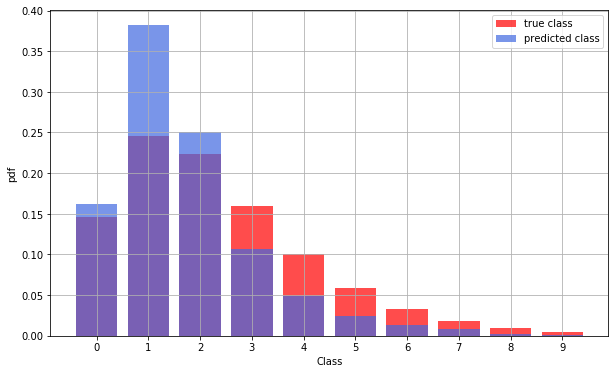

In [52]:
plt.figure(figsize=(10,6))
plt.bar(np.arange(num_bins), y_eval.sum(axis=0)/y_eval.sum(), alpha=0.7, color='red', label='true class')
plt.bar(np.arange(num_bins), y_pred_max.sum(axis=0)/y_eval.sum(), alpha=0.7, color='royalblue', label='predicted class')

plt.legend()
plt.grid()
plt.xlabel('Class')
plt.ylabel('pdf')
plt.xticks(np.arange(num_bins))
plt.savefig('output/hist_log.pdf')
plt.show()

In [53]:
# centers of the bin limits (size reduced by 1)
bin_centers = np.array([(bins[i] + (bins[i+1]-bins[i])/2) for i in range(len(bins)-1)])

In [54]:
# from one-hot encoded vector label to integer
y_eval_cls = np.argmax(y_eval, axis=1)
y_pred_cls = np.argmax(y_pred_max, axis=1)
np.unique(y_eval_cls)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [55]:
# from integer label to energy
y_eval_energy = np.zeros_like(y_eval_cls)
y_pred_energy = np.zeros_like(y_pred_cls)

for i in range(len(bin_centers)):
    y_eval_energy = np.where(y_eval_cls==i, bin_centers[i], y_eval_energy)
    y_pred_energy = np.where(y_pred_cls==i, bin_centers[i], y_pred_energy)

np.unique(y_eval_energy)

array([  149.76311575,   298.81670103,   596.21770264,  1189.61071359,
        2373.58542631,  4735.92555249,  9449.41378137, 18854.05921652,
       37618.79383891, 75059.36168136])

In [56]:
y_pred.sum(axis=0)

array([188296.05 , 325729.34 , 293844.84 , 215009.3  , 137480.72 ,
        78408.125,  43280.855,  25143.318,  12308.046,   6387.87 ],
      dtype=float32)

In [57]:
y_eval.sum(axis=0)

array([194196, 326451, 297301, 211091, 132680,  77667,  43388,  23986,
        12694,   6756], dtype=uint64)

In [58]:
perc_deviation = np.around((y_eval.sum(axis=0)-y_pred.sum(axis=0))*100/y_pred.sum(axis=0), 2)
print('Percentage deviation between the predicted(sum) and the true energy spectrum:\n')
for i,dev in enumerate(perc_deviation):
    print(f'Class {i}: {dev}%')

Percentage deviation between the predicted(sum) and the true energy spectrum:

Class 0: 3.13%
Class 1: 0.22%
Class 2: 1.18%
Class 3: -1.82%
Class 4: -3.49%
Class 5: -0.95%
Class 6: 0.25%
Class 7: -4.6%
Class 8: 3.14%
Class 9: 5.76%


In [59]:
y_pred_sum = y_pred.sum(axis=0)
y_pred_sum = np.round(y_pred_sum).astype('int')
y_pred_sum

array([188296, 325729, 293845, 215009, 137481,  78408,  43281,  25143,
        12308,   6388])

In [60]:
#(y_eval.sum(axis=0)-y_pred.sum(axis=0))*100/y_eval.sum(axis=0)

In [61]:
# to create the histogram
y_pred_sum_energy = np.array([])

for i,y in enumerate(y_pred_sum):
    y_pred_sum_energy = np.append(y_pred_sum_energy, np.ones(y)*bin_centers[i])

y_pred_sum_energy.shape, y_eval.shape

((1325888,), (1326210, 10))

In [62]:
y_eval_energy


array([298.81670103, 298.81670103, 596.21770264, ..., 298.81670103,
       596.21770264, 596.21770264])

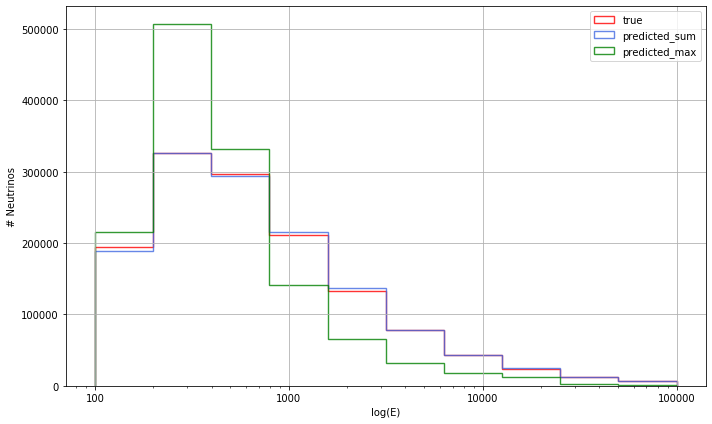

In [63]:
fig1, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(y_eval_energy, bins=bins, alpha=0.8, color='red', histtype='step', linewidth=1.4, label='true')
ax1.hist(y_pred_sum_energy, bins=bins, alpha=0.8, color='royalblue', histtype='step', linewidth=1.4, label='predicted_sum')
ax1.hist(y_pred_energy, bins=bins, alpha=0.8, color='green', histtype='step', linewidth=1.4, label='predicted_max')


ax1.set_xscale('log')
#ax1.set_xticks(bin_centers)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel('log(E)')

ax1.set_ylabel('# Neutrinos')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('output/hist_log_energy_sum.pdf')
plt.show()

# Save predictions as csv file

In [64]:
df_pred = pd.DataFrame(data=y_pred, columns=[f'Class {i}' for i in range(num_bins)])
df_pred['true label'] = y_eval_cls
df_pred.to_csv('output/y_pred.csv', index=False)

# Correlation matrix

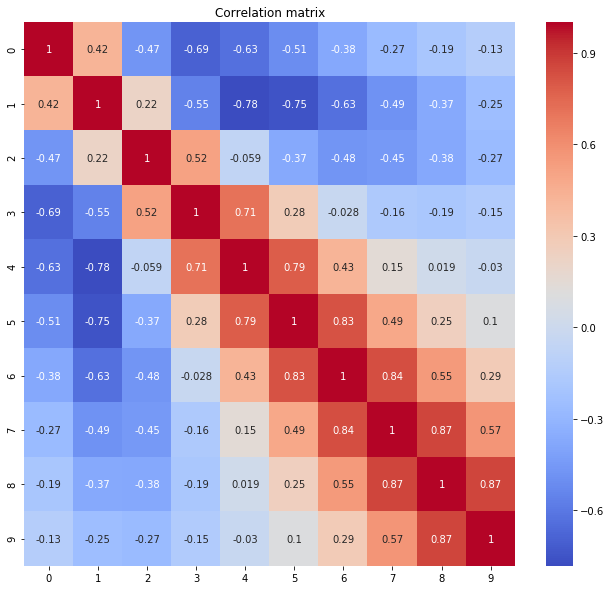

In [65]:
df_results = pd.DataFrame(data=y_pred)
plt.figure(figsize=(11,10))

ax = sns.heatmap(df_results.corr(), annot=True, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation matrix')
plt.savefig('output/correlation.png')

## Confusion Matrix

In [66]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_eval_cls, y_pred_cls)

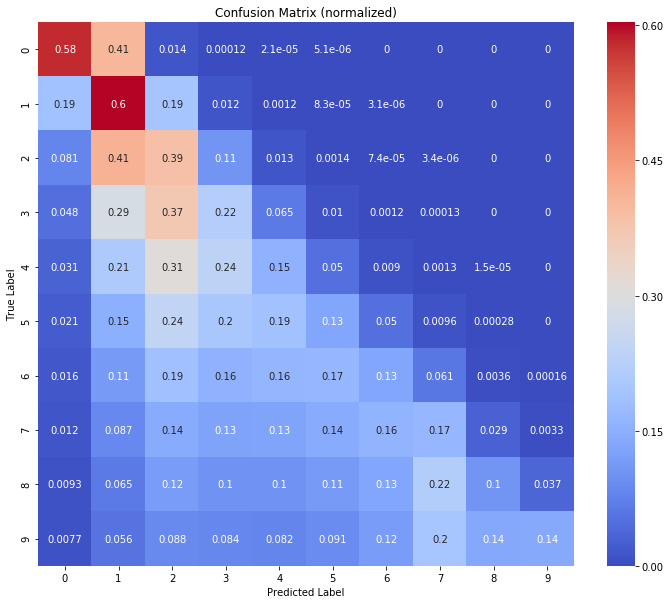

In [67]:
df_cm = pd.DataFrame(confusion_mtx/confusion_mtx.sum(axis=1)[:, np.newaxis])
plt.figure(figsize=(12,10))
#fix bug in matlotlib 3.1.0/1

ax = sns.heatmap(df_cm, annot=True, cmap='coolwarm')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (normalized)')
plt.savefig('output/cm_log2.pdf')
plt.show()

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
print('Evaluation on Evaluation data:\r')
print('Accuracy: %.4f' % accuracy_score(y_eval, y_pred_max))
print("Precision: %.4f" % precision_score(y_eval, y_pred_max, average='weighted'))
print("Recall: %.4f" % recall_score(y_eval, y_pred_max, average='weighted'))
print(classification_report(y_eval, y_pred_max))

Evaluation on Evaluation data:
Accuracy: 0.3875
Precision: 0.3769
Recall: 0.3875
              precision    recall  f1-score   support

           0       0.52      0.58      0.55    194196
           1       0.39      0.60      0.47    326451
           2       0.35      0.39      0.36    297301
           3       0.33      0.22      0.27    211091
           4       0.31      0.15      0.21    132680
           5       0.32      0.13      0.19     77667
           6       0.33      0.13      0.19     43388
           7       0.34      0.17      0.22     23986
           8       0.42      0.10      0.17     12694
           9       0.63      0.14      0.23      6756

   micro avg       0.39      0.39      0.39   1326210
   macro avg       0.40      0.26      0.29   1326210
weighted avg       0.38      0.39      0.37   1326210
 samples avg       0.39      0.39      0.39   1326210



In [69]:
from sklearn.metrics import jaccard_score
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
#'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account

jaccard_score = jaccard_score(y_eval, y_pred_max, average='micro')
print('Jaccard-Score: %.4f' % jaccard_score)

Jaccard-Score: 0.2403
